In [2]:
import torch
import os
import copy
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models

#from misc_functions import get_example_params, convert_to_grayscale, save_gradient_images


In [62]:

def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('results'):
        os.makedirs('results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('results', file_name + '.jpg')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('results'):
        os.makedirs('results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = (('snake.jpg', 56),
                    ('cat_dog.png', 243),
                    ('spider.png', 72))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

In [32]:
example_list = (('snake.jpg', 56),
                    ('cat_dog.png', 243),
                    ('spider.png', 72))
img_path = example_list[1][0]

In [33]:
target_class = example_list[1][1]
file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]

In [34]:
file_name_to_export


'cat_dog'

In [35]:
target_class

243

In [36]:
img_path

'cat_dog.png'

In [37]:
class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [38]:
if __name__ == '__main__':
    # Get params
    target_example = 1  # Snake
    (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
        get_example_params(target_example)
    # Vanilla backprop
    VBP = VanillaBackprop(pretrained_model)
    # Generate gradients
    vanilla_grads = VBP.generate_gradients(prep_img, target_class)
    # Save colored gradients
    save_gradient_images(vanilla_grads, file_name_to_export + '_Vanilla_BP_color')
    # Convert to grayscale
    grayscale_vanilla_grads = convert_to_grayscale(vanilla_grads)
    # Save grayscale gradients
    save_gradient_images(grayscale_vanilla_grads, file_name_to_export + '_Vanilla_BP_gray')
    print('Vanilla backprop completed')

Vanilla backprop completed


In [43]:
import matplotlib.pyplot as plt


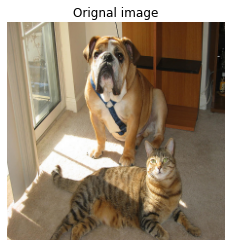

In [46]:
# Opening the image
img = Image.open('/content/cat_dog.png') 
plt.imshow(img)
plt.title('Orignal image')
plt.axis('off');

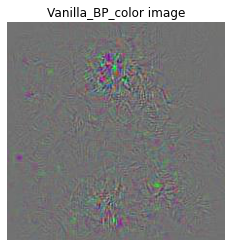

In [44]:
image = Image.open('/content/results/cat_dog_Vanilla_BP_color.jpg')

plt.imshow(image)
plt.title('Vanilla_BP_color image')
plt.axis('off');

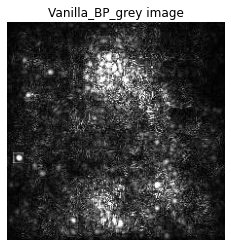

In [47]:
image1 = Image.open('/content/results/cat_dog_Vanilla_BP_gray.jpg')

plt.imshow(image1)
plt.title('Vanilla_BP_grey image')
plt.axis('off');

In [49]:
from torch.nn import ReLU

In [50]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


if __name__ == '__main__':
    target_example = 0  # Snake
    (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
        get_example_params(target_example)

    # Guided backprop
    GBP = GuidedBackprop(pretrained_model)
    # Get gradients
    guided_grads = GBP.generate_gradients(prep_img, target_class)
    # Save colored gradients
    save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
    # Convert to grayscale
    grayscale_guided_grads = convert_to_grayscale(guided_grads)
    # Save grayscale gradients
    save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
    # Positive and negative saliency maps
    pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
    save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
    save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
    print('Guided backprop completed')

Guided backprop completed


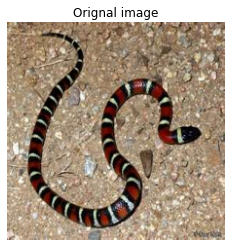

In [51]:
# Opening the image
img = Image.open('/content/snake.jpg') 
plt.imshow(img)
plt.title('Orignal image')
plt.axis('off');

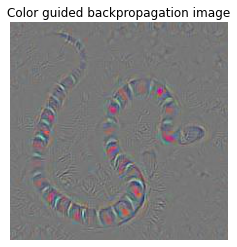

In [56]:
image = Image.open('/content/results/snake_Guided_BP_color.jpg')

plt.imshow(image)
plt.title('Color guided backpropagation image')
plt.axis('off');

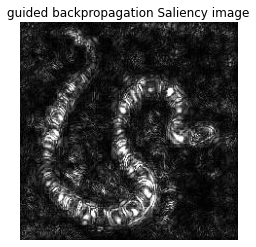

In [57]:
image = Image.open('/content/results/snake_Guided_BP_gray.jpg')

plt.imshow(image)
plt.title('guided backpropagation Saliency image')
plt.axis('off');

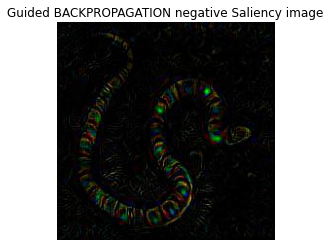

In [58]:
image = Image.open('/content/results/snake_neg_sal.jpg')

plt.imshow(image)
plt.title('Guided BACKPROPAGATION negative Saliency image')
plt.axis('off');

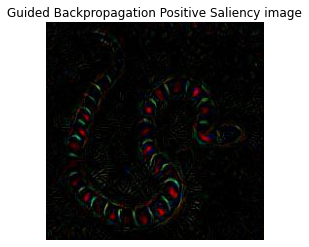

In [59]:
image = Image.open('/content/results/snake_pos_sal.jpg')

plt.imshow(image)
plt.title('Guided Backpropagation Positive Saliency image')
plt.axis('off');

In [63]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255

        # You can also use the code below instead of the code line above, suggested by @ ptschandl
        # from scipy.ndimage.interpolation import zoom
        # cam = zoom(cam, np.array(input_image[0].shape[1:])/np.array(cam.shape))
        return cam


if __name__ == '__main__':
    # Get params
    target_example = 0  # Snake
    (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
        get_example_params(target_example)
    # Grad cam
    grad_cam = GradCam(pretrained_model, target_layer=11)
    # Generate cam mask
    cam = grad_cam.generate_cam(prep_img, target_class)
    # Save mask
    save_class_activation_images(original_image, cam, file_name_to_export)
    print('Grad cam completed')

Grad cam completed


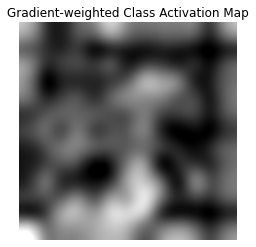

In [70]:
image = Image.open('/content/results/snake_Cam_Grayscale.png')

plt.imshow(image)
plt.title('Gradient-weighted Class Activation Map')
plt.axis('off');

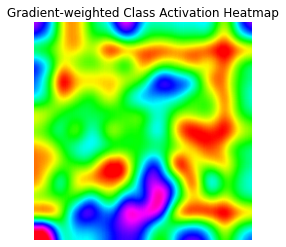

In [69]:
image = Image.open('/content/results/snake_Cam_Heatmap.png')

plt.imshow(image)
plt.title('Gradient-weighted Class Activation Heatmap')
plt.axis('off');

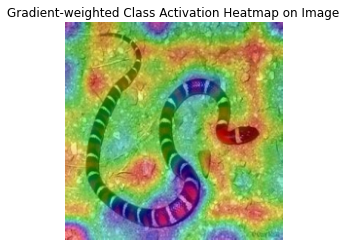

In [68]:
image = Image.open('/content/results/snake_Cam_On_Image.png')

plt.imshow(image)
plt.title('Gradient-weighted Class Activation Heatmap on Image')
plt.axis('off');

In [71]:
# from guided_backprop import GuidedBackprop  # To use with guided backprop
# from integrated_gradients import IntegratedGradients  # To use with integrated grads

if __name__ == '__main__':
    # Get params
    target_example = 0  # Snake
    (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
        get_example_params(target_example)
    # Vanilla backprop
    VBP = VanillaBackprop(pretrained_model)
    # Generate gradients
    vanilla_grads = VBP.generate_gradients(prep_img, target_class)

    # Make sure dimensions add up!
    grad_times_image = vanilla_grads * prep_img.detach().numpy()[0]
    # Convert to grayscale
    grayscale_vanilla_grads = convert_to_grayscale(grad_times_image)
    # Save grayscale gradients
    save_gradient_images(grayscale_vanilla_grads,
                         file_name_to_export + '_Vanilla_grad_times_image_gray')
    print('Grad times image completed.')

Grad times image completed.


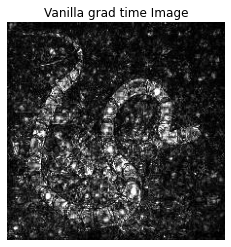

In [76]:
image = Image.open('/content/results/snake_Vanilla_grad_times_image_gray.jpg')

plt.imshow(image)
plt.title('Vanilla grad time Image')
plt.axis('off');

In [75]:
class IntegratedGradients():
    """
        Produces gradients generated with integrated gradients from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_images_on_linear_path(self, input_image, steps):
        # Generate uniform numbers between 0 and steps
        step_list = np.arange(steps+1)/steps
        # Generate scaled xbar images
        xbar_list = [input_image*step for step in step_list]
        return xbar_list

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

    def generate_integrated_gradients(self, input_image, target_class, steps):
        # Generate xbar images
        xbar_list = self.generate_images_on_linear_path(input_image, steps)
        # Initialize an iamge composed of zeros
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            # Generate gradients from xbar images
            single_integrated_grad = self.generate_gradients(xbar_image, target_class)
            # Add rescaled grads from xbar images
            integrated_grads = integrated_grads + single_integrated_grad/steps
        # [0] to get rid of the first channel (1,3,224,224)
        return integrated_grads[0]


if __name__ == '__main__':
    # Get params
    target_example = 0  # Snake
    (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
        get_example_params(target_example)
    # Vanilla backprop
    IG = IntegratedGradients(pretrained_model)
    # Generate gradients
    integrated_grads = IG.generate_integrated_gradients(prep_img, target_class, 100)
    # Convert to grayscale
    grayscale_integrated_grads = convert_to_grayscale(integrated_grads)
    # Save grayscale gradients
    save_gradient_images(grayscale_integrated_grads, file_name_to_export + '_Integrated_G_gray')
    print('Integrated gradients completed.')

Integrated gradients completed.


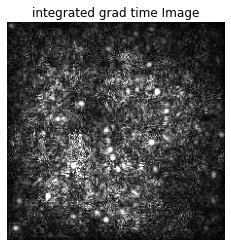

In [78]:
image = Image.open('/content/results/snake_Integrated_G_gray.jpg')

plt.imshow(image)
plt.title('integrated grad time Image')
plt.axis('off');